### __Loading data + synching them__

In [1]:
%load_ext autoreload
%autoreload 2

### __Texture Mapping__

In [2]:
from modules.ogm import *
from modules.utils import *
from modules.sensors import *
from modules.localization import *
from modules.texture_mapping import *
from modules.pose_graph_optimization import *

import numpy as np
from math import radians as rd
import matplotlib.pyplot as plt

#----------------------------------------------------------------------------
# Loading data and syncing sensors
dataset_num = 20 # or 21
dataset_names = {
    "encoder": "Encoders",
    "lidar": "Hokuyo",
    "imu": "Imu",
    "rgbd": "Kinect",
}

data = load_data(dataset_num, dataset_names)
encoder = Encoder(data["encoder"])
lidar = Lidar(data["lidar"])
imu = Imu(data["imu"])
kinect = Kinect(data["rgbd"])

synchronize_sensors(encoder, imu, lidar, base_sensor_index=0)
#----------------------------------------------------------------------------

# Estimate poses
z_ts = get_lidar_data(lidar.ranges_synced, lidar.range_min, lidar.range_max)
v_ts = encoder.counts_synced
w_ts = imu.gyro_synced
# poses_odom, relative_poses_odom = poses_from_odometry(v_ts, w_ts, return_relative_poses=True)
# poses_scan_matching, relative_poses_scan_matching = poses_from_scan_matching(poses_odom, z_ts, return_relative_poses=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# save_numpy(poses_odom, "poses_odom.npy")
# save_numpy(relative_poses_odom, "relative_poses_odom.npy")

# save_numpy(poses_scan_matching, "poses_scan_matching.npy")
# save_numpy(relative_poses_scan_matching, "relative_poses_scan_matching.npy")

In [4]:
poses_odom = load_numpy("poses_odom.npy")
relative_poses_odom = load_numpy("relative_poses_odom.npy")

poses_scan_matching = load_numpy("poses_scan_matching.npy")
relative_poses_scan_matching = load_numpy("relative_poses_scan_matching.npy")

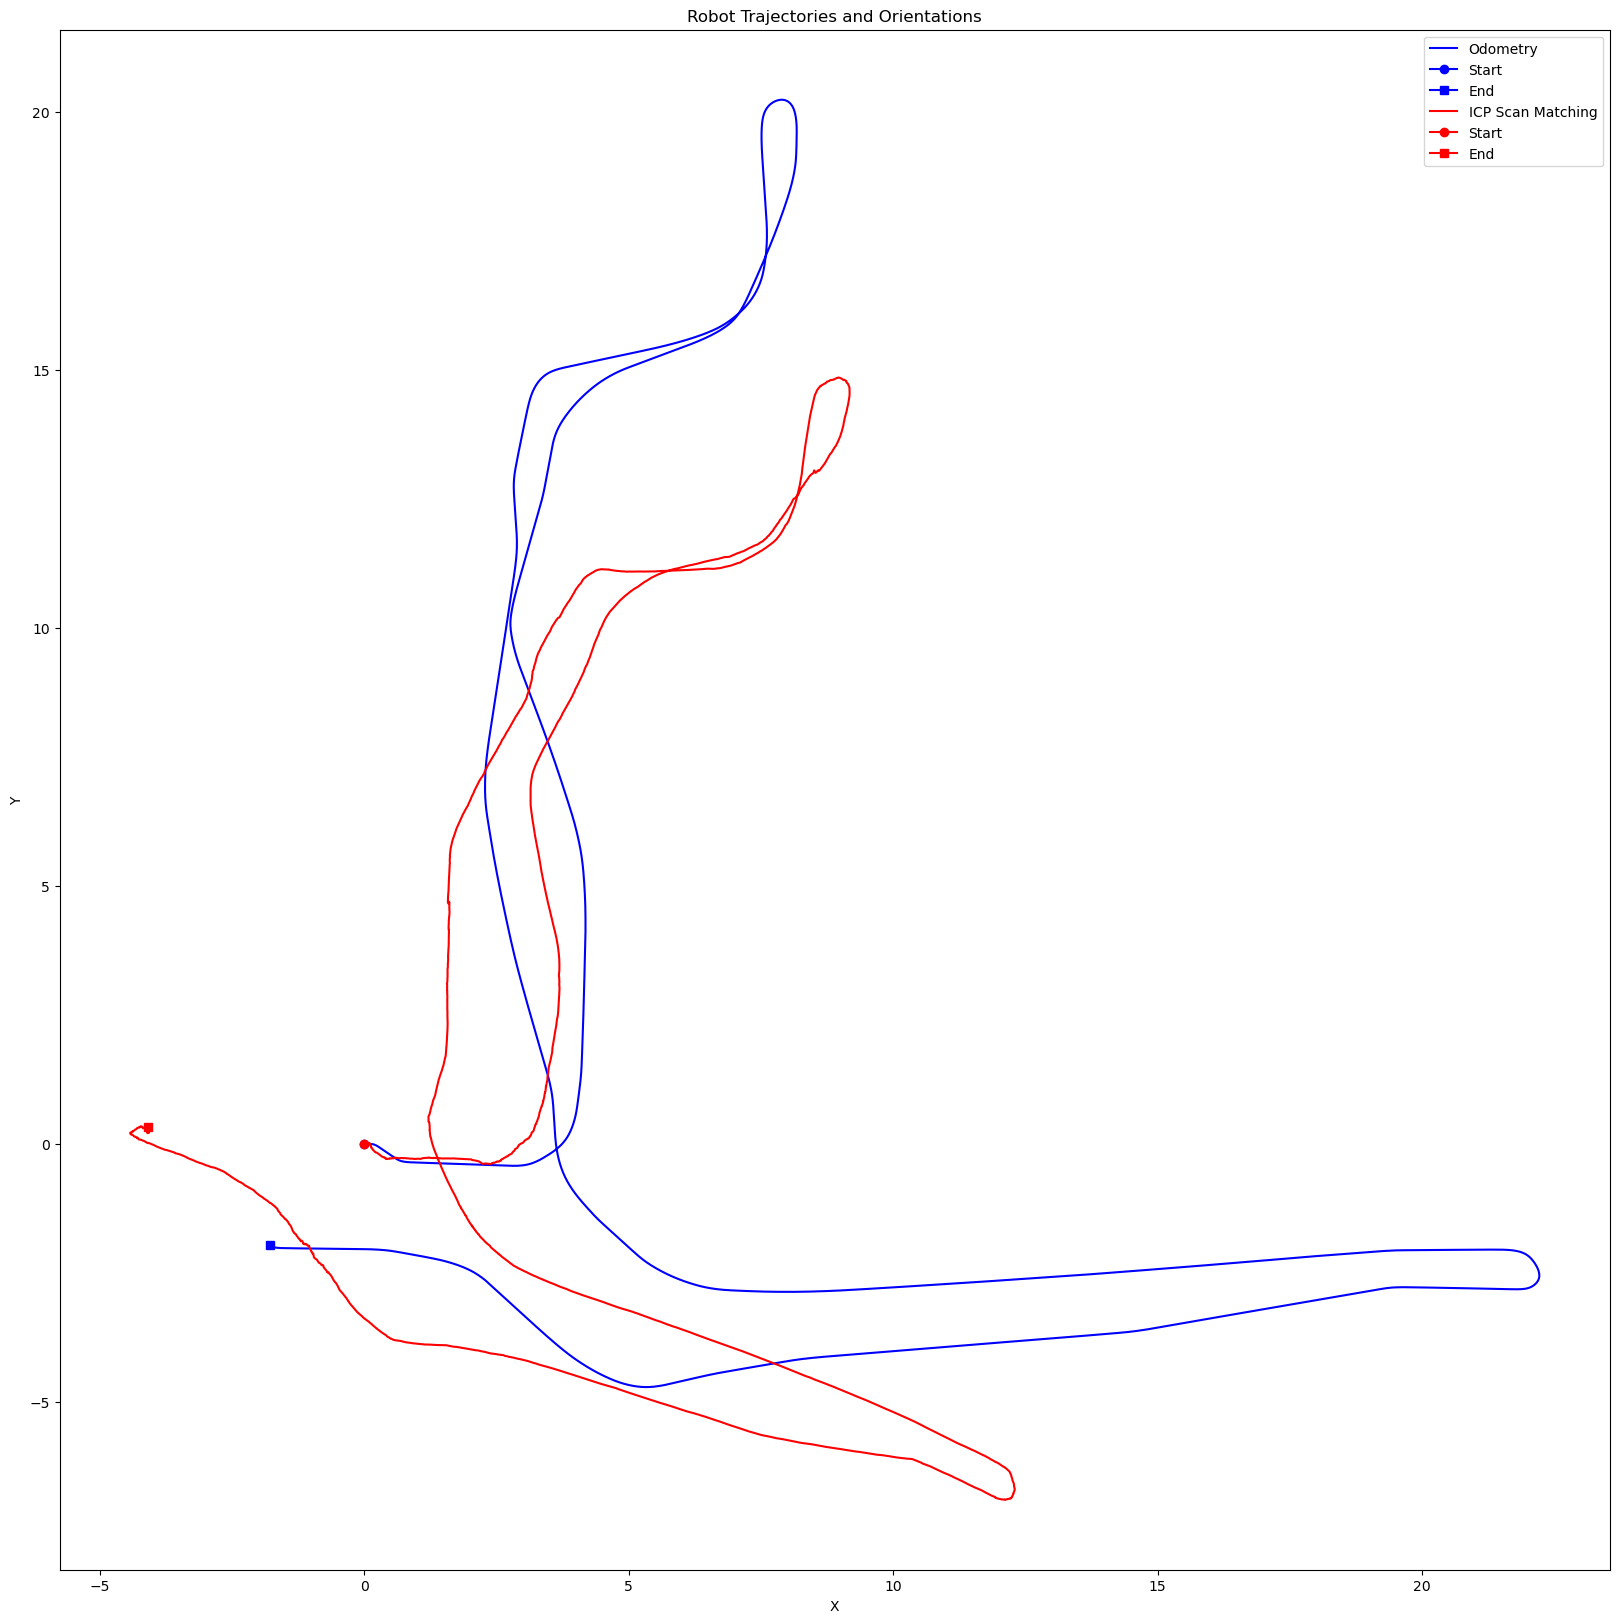

In [5]:
labels = [
    "Odometry",
    "ICP Scan Matching",
]
plot_N_trajectories([poses_odom, poses_scan_matching], labels=labels, figsize=(20, 20))

In [6]:
import numpy as np
from scipy.spatial.distance import pdist, squareform


distances = pdist(poses_scan_matching[:, :2], metric='euclidean')
distance_matrix = squareform(distances)

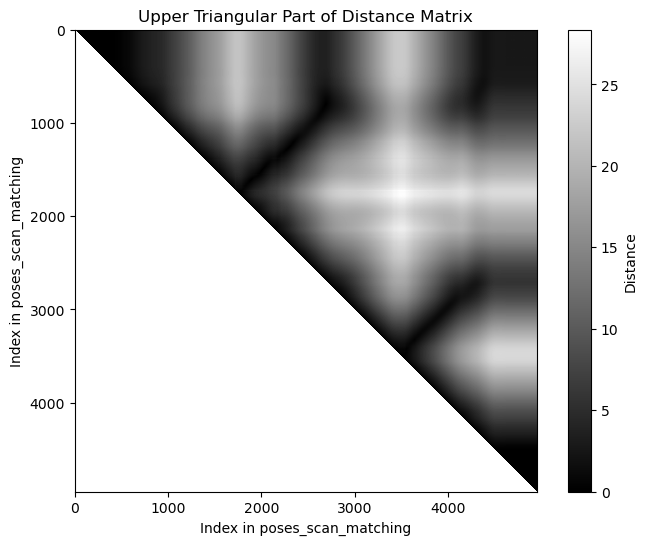

In [7]:
# Create a mask for the upper triangular part of the matrix
mask = np.triu(np.ones_like(distance_matrix, dtype=bool), k=1)  # k=1 excludes the diagonal

# Apply the mask to the distance matrix
# np.ma.array creates a masked array hiding the elements where mask is False
masked_distance_matrix = np.ma.array(distance_matrix, mask=~mask)  # ~mask inverts the mask
np.fill_diagonal(masked_distance_matrix, np.max(np.max(distance_matrix, axis=0)))

plt.figure(figsize=(8, 6))
plt.imshow(masked_distance_matrix, cmap='gray', interpolation='none')
plt.colorbar(label='Distance')
plt.title('Upper Triangular Part of Distance Matrix')
plt.xlabel('Index in poses_scan_matching')
plt.ylabel('Index in poses_scan_matching')
plt.show()

In [137]:
from scipy.spatial import KDTree
import numpy as np

def distance_travelled_and_time(v_ts, stamps):
    """
    Compute the distance travelled so far and time elapsed at each pose.
    
    Args:
        v_ts: The encoder data with shape (N, 4)
        stamps: The time stamps for each encoder reading
    
    Returns:
        The distance travelled and time elapsed at every pose.
    """
    d = 0
    dist_travelled = [0]
    time_elapsed = [0]  # Initialize with zero time elapsed at the start
    for i in range(1, v_ts.shape[0]):
        dist = dist_travelled_from_encoder(v_ts[i])
        d += dist
        dist_travelled.append(d)
        # Calculate time elapsed since the start
        time_elapsed.append(stamps[i] - stamps[0])
    return dist_travelled, time_elapsed

def build_kd_tree(poses):
    """
    Build a KDTree for efficient nearest neighbor searches.
    
    Args:
        poses: An array of pose coordinates, shape (N, 3), where N is the number of poses.
    
    Returns:
        A KDTree built from the poses.
    """
    return KDTree(poses[:, :2])

def find_nearby_pose_pairs(dists_travelled, kd_tree, poses, max_distance, time_elapsed, min_time_diff):
    """
    Find nearby pose pairs using a KDTree, filtering by maximum distance and minimum time difference.
    
    Args:
        kd_tree: A KDTree object built from pose coordinates.
        poses: An array of pose coordinates, shape (N, 3).
        max_distance: The maximum distance between poses to consider as nearby.
        time_elapsed: An array of time elapsed values corresponding to each pose.
        min_time_diff: The minimum time difference between poses to consider.
    
    Returns:
        A list of tuples, each containing the indices of a valid pose pair.
    """
    nearby_pairs = []
    for i in range(poses.shape[0]):
        # Query the KDTree for nearby points within max_distance
        indices = kd_tree.query_ball_point(poses[i, :2], max_distance)
        for j in indices:
            if i != j:  # Avoid self-matching
                time_diff = abs(time_elapsed[i] - time_elapsed[j])
                d_btween_poses = dists_travelled[i] - dists_travelled[j]
                if (time_diff >= min_time_diff) and (abs(d_btween_poses) >= 0) :
                    # Ensure unique pairs with i < j to avoid duplicates
                    if i < j:
                        nearby_pairs.append((i, j))
    return nearby_pairs

def plot_histogram(descriptor, num_bins=20):
    plt.bar(range(num_bins), descriptor)
    plt.xlabel('Bin')
    plt.ylabel('Count')
    plt.title('Histogram Descriptor for a LiDAR Scan')
    plt.show()
    
def compute_histogram_descriptors(z_ts, num_bins=20, range_max=10):
    """
    Compute histogram descriptors for each LiDAR scan.
    
    Args:
        z_ts: List of LiDAR scans, each scan is an array of shape (K, 2).
        num_bins: Number of bins in the histogram.
        range_max: Maximum range to consider for histogram bins.
    
    Returns:
        A list of histogram descriptors, one for each scan.
    """
    histograms = []
    for z in z_ts:
        # Compute the distance of each point from the origin (0, 0)
        distances = np.sqrt(np.sum(z**2, axis=1))
        # Compute the histogram
        hist, _ = np.histogram(distances, bins=num_bins, range=(0, range_max))
        # Normalize the histogram to make it a distribution
        hist = hist / np.sum(hist)
        histograms.append(hist)
    return histograms

def filter_pairs_by_descriptors(pairs, descriptors, threshold=0.2):
    """
    Filter pairs of scans based on their histogram descriptors.
    
    Args:
        pairs: List of tuples, each containing the indices of a pair of scans.
        descriptors: List of histogram descriptors for each scan.
        threshold: Distance threshold below which pairs are considered similar.
    
    Returns:
        A list of tuples, each containing the indices of pairs that are similar based on their descriptors.
    """
    filtered_pairs = []
    for i, j in pairs:
        # Compute distance between descriptors
        distance = np.linalg.norm(descriptors[i] - descriptors[j])
        if distance < threshold:
            filtered_pairs.append((i, j))
    return filtered_pairs

def vectorized_filter_pairs_by_descriptors(pairs, descriptors, threshold=0.2):
    """
    Vectorized filtering of pairs of scans based on their histogram descriptors.
    
    Args:
        pairs: List of tuples, each containing the indices of a pair of scans.
        descriptors: List of histogram descriptors for each scan.
        threshold: Distance threshold below which pairs are considered similar.
    
    Returns:
        A list of tuples, each containing the indices of pairs that are similar based on their descriptors.
    """
    # Convert pairs list to a NumPy array for advanced indexing
    pairs_array = np.array(pairs)
    
    # Extract the descriptors for each pair
    first_descriptors = np.array(descriptors)[pairs_array[:, 0]]
    second_descriptors = np.array(descriptors)[pairs_array[:, 1]]
    
    # Compute the distances between descriptors for each pair
    distances = np.linalg.norm(first_descriptors - second_descriptors, axis=1)
    
    # Find pairs where distance is below the threshold
    similar_pairs_mask = distances < threshold
    
    # Filter pairs based on the mask
    similar_pairs_indices = pairs_array[similar_pairs_mask]
    
    # Convert filtered indices back to list of tuples
    filtered_pairs = list(map(tuple, similar_pairs_indices))
    
    return filtered_pairs

def remove_redundant_pairs(pairs, time_elapsed, min_time_diff):
    """
    Remove pairs that are unnecessary by ensuring a significant time difference
    between subsequent elements within grouped pairs.

    Args:
        pairs: List of tuples, each containing the indices of a pair of poses.
        time_elapsed: List of time elapsed for each pose.
        min_time_diff: Minimum time difference to consider a pair as significant.

    Returns:
        A list of tuples with the filtered pairs.
    """
    from collections import defaultdict

    # Group pairs by the first element
    grouped_pairs = defaultdict(list)
    for i, j in pairs:
        grouped_pairs[i].append(j)

    # Sort each group by the second element (time)
    for i in grouped_pairs.keys():
        grouped_pairs[i].sort(key=lambda x: time_elapsed[x])

    # Filter out unnecessary pairs
    filtered_pairs = []
    for i, group in grouped_pairs.items():
        # Initialize with the first pair in the group
        if not group:
            continue
        last_j = group[0]
        filtered_pairs.append((i, last_j))
        for j in group[1:]:
            if time_elapsed[j] - time_elapsed[last_j] >= min_time_diff:
                filtered_pairs.append((i, j))
                last_j = j

    return filtered_pairs

In [138]:
def apply_filters(dists_travelled, v_ts, stamps, poses_scan_matching, z_ts, 
                  kdtree=True, histogram=True, redundancy=True,
                  max_distance=5.0, min_time_diff=20.0, num_bins=20, range_max=10, descriptor_threshold=0.2):
    """
    Apply various filters based on boolean flags.
    
    Args:
        v_ts: The encoder data with shape (N, 4).
        stamps: The time stamps for each encoder reading.
        poses_scan_matching: Pose coordinates for scan matching, shape (N, 3).
        z_ts: List of LiDAR scans, each scan is an array of shape (K, 2).
        kdtree: Boolean flag to apply KDTree filter.
        histogram: Boolean flag to apply histogram descriptor filter.
        redundancy: Boolean flag to apply redundancy removal filter.
        max_distance: Maximum distance for KDTree search.
        min_time_diff: Minimum time difference for filtering.
        num_bins: Number of bins for histogram computation.
        range_max: Maximum range for histogram computation.
        descriptor_threshold: Threshold for filtering based on histogram descriptors.
    
    Returns:
        A list of filtered pose pairs.
    """
    # Initialize filters result
    filtered_pairs = []

    if kdtree:
        # Build KDTree and find nearby pose pairs
        kd_tree = build_kd_tree(poses_scan_matching)
        nearby_pairs = find_nearby_pose_pairs(dists_travelled, kd_tree, poses_scan_matching, max_distance, time_elapsed, min_time_diff)
        filtered_pairs = nearby_pairs
        print(f"Found {len(nearby_pairs)} nearby pose pairs using KDTree.")
    
    if histogram and filtered_pairs:
        # Compute histogram descriptors for each scan and filter pairs
        histogram_descriptors = compute_histogram_descriptors(z_ts, num_bins, range_max)
        filtered_pairs = vectorized_filter_pairs_by_descriptors(filtered_pairs, histogram_descriptors, descriptor_threshold)
        print(f"Filtered down to {len(filtered_pairs)} pairs based on histogram descriptors.")
    
    if redundancy and filtered_pairs:
        # Remove redundant pairs
        filtered_pairs = remove_redundant_pairs(filtered_pairs, time_elapsed, min_time_diff)
        filtered_pairs = np.array(filtered_pairs)
        temp = filtered_pairs[:, [1, 0]]
        filtered_pairs = list(map(tuple, filtered_pairs))
        final_filtered_pairs = remove_redundant_pairs(list(map(tuple, temp)), time_elapsed, min_time_diff)
        final_filtered_pairs = np.array(final_filtered_pairs)
        final_filtered_pairs = final_filtered_pairs[:, [1, 0]]
        final_filtered_pairs = list(map(tuple, final_filtered_pairs))
        print(f"Count of pairs after removing redundancies: {len(final_filtered_pairs)}")
    
    return final_filtered_pairs

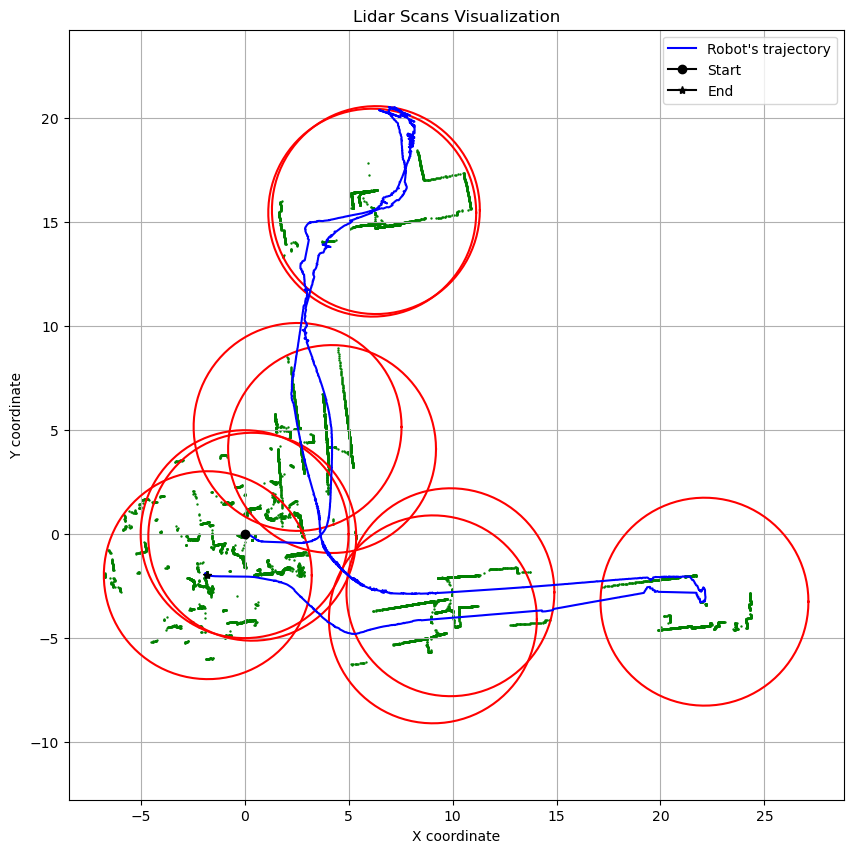

In [139]:
# Function to filter points too close or too far
def filter_scans(lidar_scans, min_dist, max_dist):
    filtered_scans = []
    for scan in lidar_scans:
        distances = np.sqrt(np.sum(np.square(scan), axis=1))  # Calculate distances from (0, 0)
        mask = (distances > min_dist) & (distances < max_dist)  # Create mask for valid distances
        filtered_scans.append(scan[mask])  # Apply mask
    return filtered_scans
too_close = 0.1
too_far = 5.
z_ts_filtered = filter_scans(z_ts, too_close, too_far)
# z_ts_filtered = z_ts

z_ts_w = []
for i in range(len(z_ts_filtered)):
    pose = poses_scan_matching[i]
    x, y, theta = pose
    T = np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])
    
    z = np.hstack((z_ts_filtered[i], np.ones((z_ts_filtered[i].shape[0], 1))))
    z = transform_points(z, T)
    z_ts_w.append(z[:, :2])

r = 5.

plt.figure(figsize=(10, 10))
theta = np.linspace(0, 2*np.pi, 100)
for i in range(0, len(z_ts_w), 500):
    xr = poses_scan_matching[i, 0]
    yr = poses_scan_matching[i, 1]
    x = r*np.cos(theta) + xr
    y = r*np.sin(theta) + yr
    
    plt.scatter(z_ts_w[i][:, 0], z_ts_w[i][:, 1], s=0.5, color='green')
    plt.plot(x, y, 'r-')

xr = poses_scan_matching[:, 0]
yr = poses_scan_matching[:, 1]
plt.plot(xr, yr, label="Robot's trajectory", color='blue')
start_pose = poses_scan_matching[0, :2]
end_pose = poses_scan_matching[-1, :2]
xs, ys = start_pose 
xe, ye = end_pose 
plt.plot(xs, ys, marker='o', color='black', label='Start')
plt.plot(xe, ye, marker='*', color='black', label='End')
plt.title('Lidar Scans Visualization')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [144]:
# Example of calling the new apply_filters function
min_time_diff = 0.2
dists_travelled, time_elapsed = distance_travelled_and_time(v_ts, encoder.stamps)
final_filtered_pairs = apply_filters(dists_travelled, v_ts, encoder.stamps, poses_scan_matching, z_ts_filtered, 
                                     kdtree=True, histogram=True, redundancy=True,
                                     max_distance=r, min_time_diff=min_time_diff)
print(f"Final count of pairs after applying filters: {len(final_filtered_pairs)}")

t1t2_relative_poses_scan_matching = []
for i in range(relative_poses_scan_matching.shape[0]):
    t1t2_relative_poses_scan_matching.append(
        np.linalg.inv(relative_poses_scan_matching[i])
    )
t1t2_relative_poses_scan_matching = np.array(t1t2_relative_poses_scan_matching)

loop_pairs_motion_model_relative_poses = []
for i in tqdm(range(len(final_filtered_pairs))):
    t1 = final_filtered_pairs[i][0]
    t1 = poses_scan_matching[t1]
    
    t2 = final_filtered_pairs[i][1]
    t2 = poses_scan_matching[t2]
    
    loop_pairs_motion_model_relative_poses.append(
        get_relative_pose(t2, t1)
    )
loop_pairs_motion_model_relative_poses = np.array(loop_pairs_motion_model_relative_poses)

Found 2800533 nearby pose pairs using KDTree.
Filtered down to 684864 pairs based on histogram descriptors.
Count of pairs after removing redundancies: 31318
Final count of pairs after applying filters: 31318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31318/31318 [00:00<00:00, 41193.29it/s]


In [149]:
# threshold_diff = 100
# loop_closure_constraints, aligned_poses = pose_graph_optimization(
#     poses_scan_matching,
#     t1t2_relative_poses_scan_matching,
#     z_ts_w,
#     final_filtered_pairs,
#     loop_pairs_t1t2_motion_model_relative_poses,
#     threshold_diff
# )

Getting loop closure constraints...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 213.65it/s]

Avg diff: 5.46030710919553
Number of loop closure constraints: 100


In [150]:
def transform_lidar_pc(pc1, TSE3):
    assert TSE3.shape == (4, 4)
    T = TSE2_from_TSE3(TSE3)
    pc1 = np.hstack((pc1, np.ones((pc1.shape[0], 1))))
    res = transform_points(pc1, T)
    return res[:, :2]

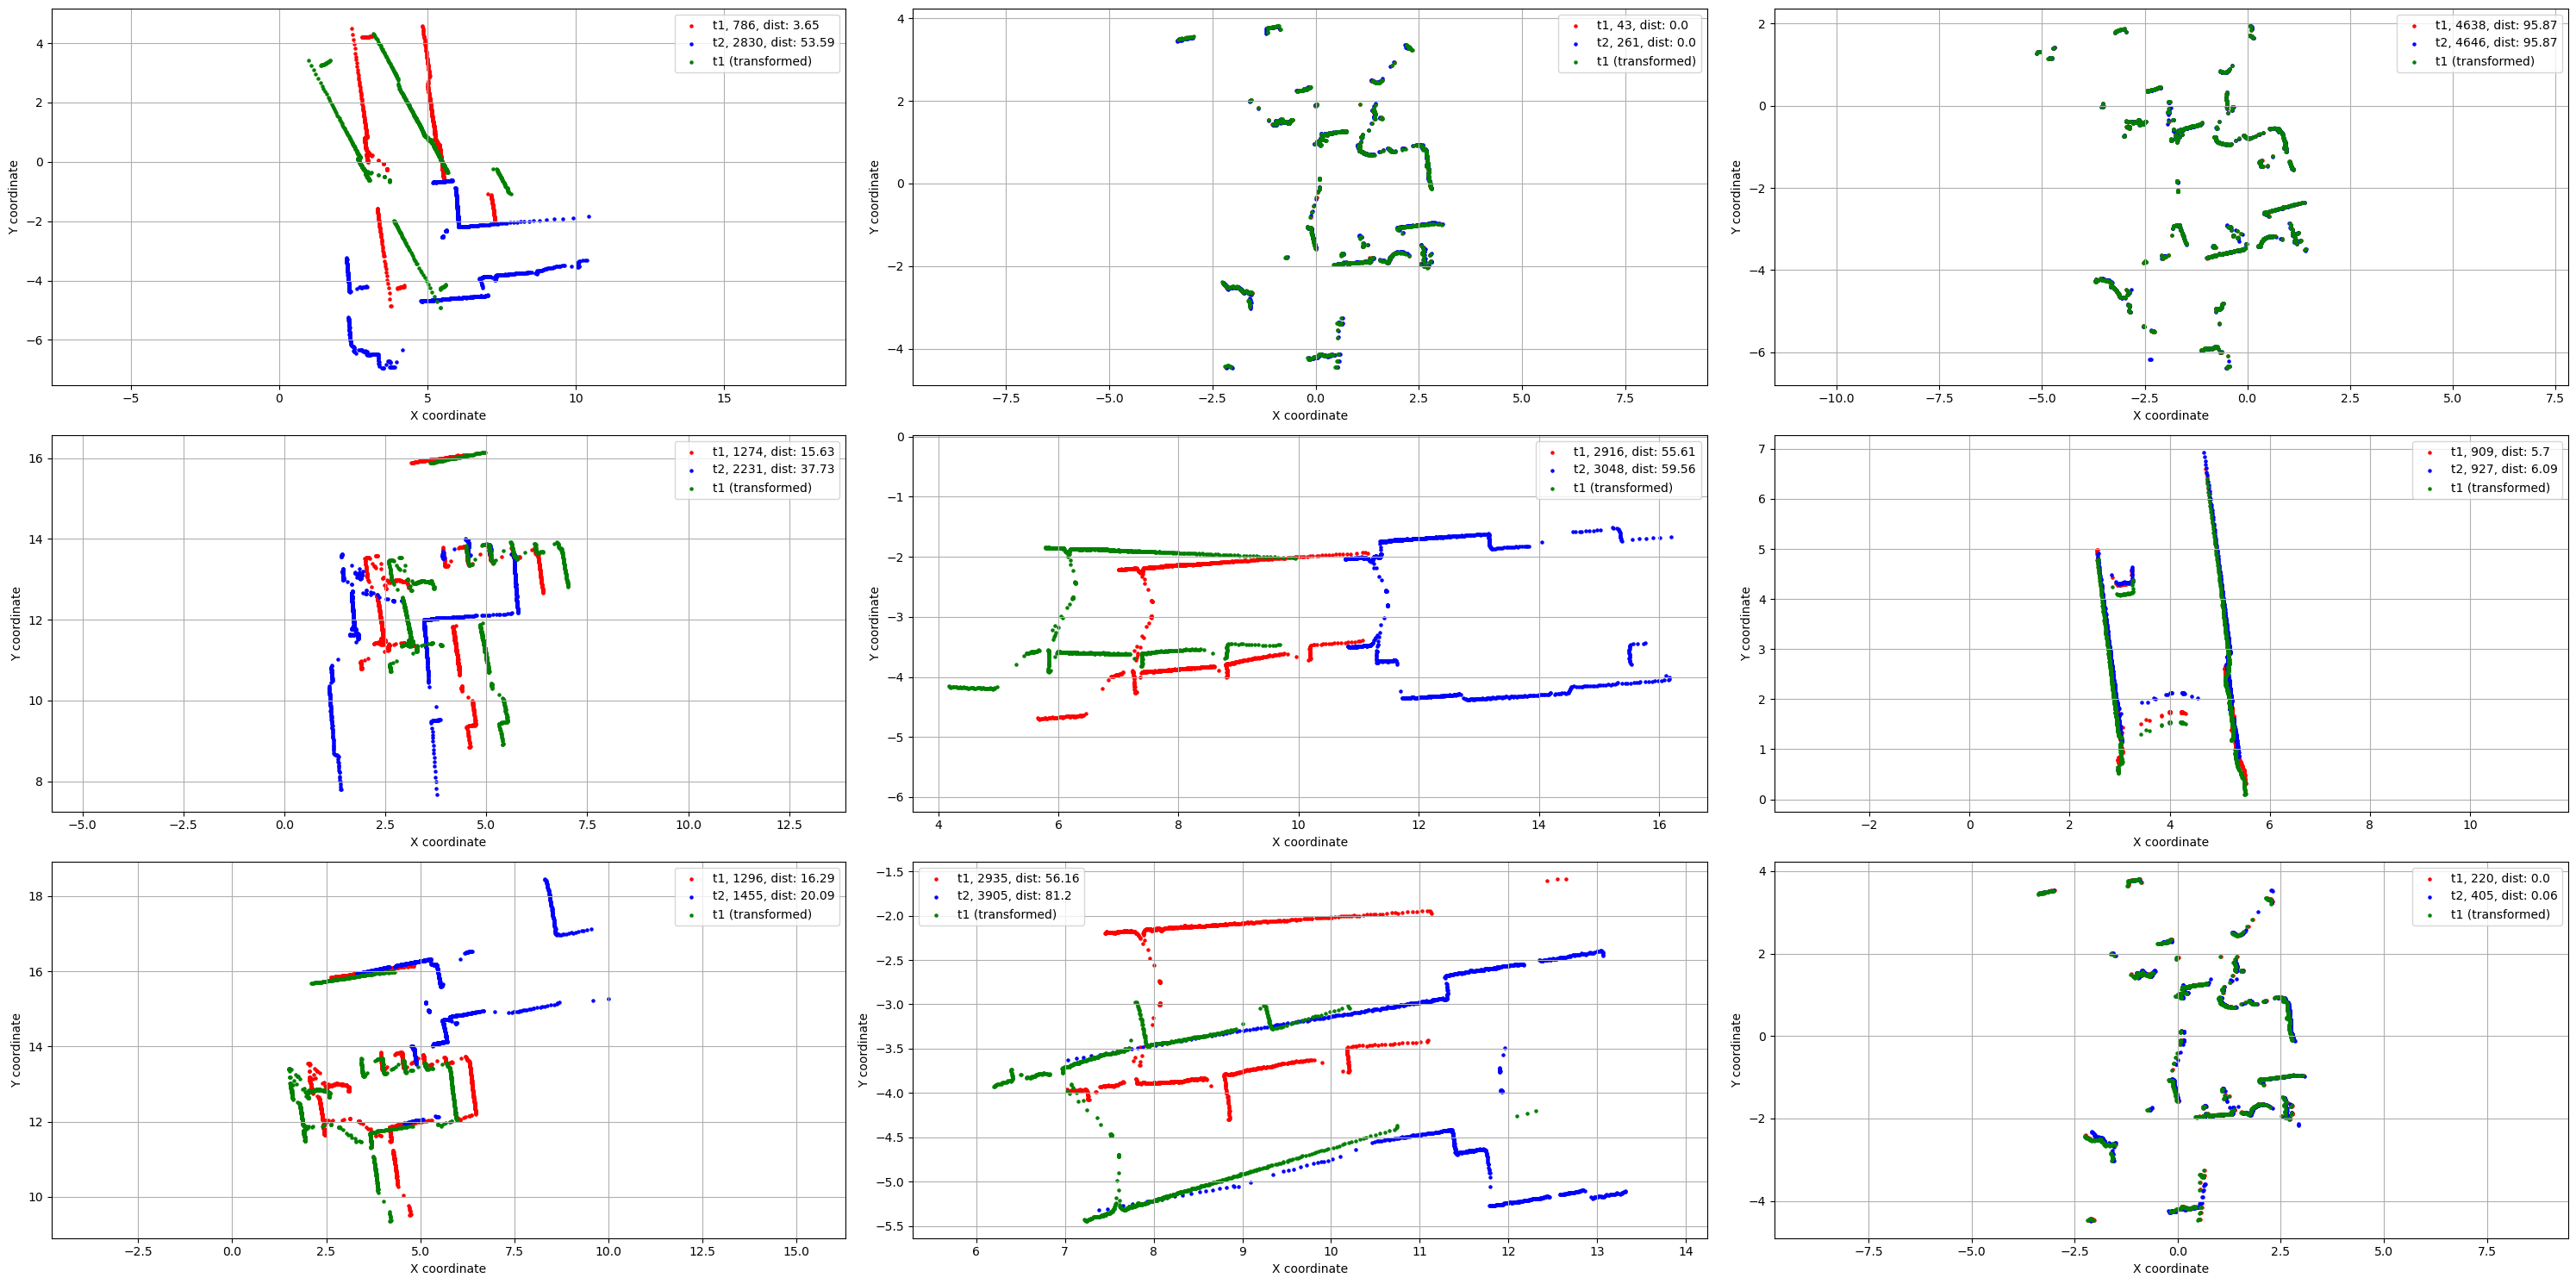

In [151]:
# import matplotlib.pyplot as plt
# import random

# # Assuming aligned_poses and z_ts_w are predefined dictionaries containing your data
# fig, axs = plt.subplots(3, 3, figsize=(30, 15))  # Create a 3x3 grid of subplots
# axs = axs.flatten()  # Flatten the 2D array of axes to easily loop over it

# keys = list(aligned_poses.keys())
# random.shuffle(keys)  # Shuffle the list of keys

# # Ensure we only take the first 9 unique keys after shuffling
# for ax, sampler in zip(axs, keys[:9]):
#     t1, t2 = sampler[0], sampler[1]
#     data_t1 = z_ts_w[t1]
#     data_t2 = z_ts_w[t2]
#     registered = transform_lidar_pc(data_t1, aligned_poses[sampler])  # Assuming this function is defined elsewhere

#     # Plot on the current subplot axis
#     l1 = "t1, " + str(t1) + ", dist: " + str(round(dists_travelled[t1], 2))
#     l2 = "t2, " + str(t2) + ", dist: " + str(round(dists_travelled[t2], 2))
#     ax.scatter(data_t1[:, 0], data_t1[:, 1], s=5, color='red', label=l1)
#     ax.scatter(data_t2[:, 0], data_t2[:, 1], s=5, color='blue', label=l2)
#     ax.scatter(registered[:, 0], registered[:, 1], s=5, color='green', label='t1 (transformed)')
#     ax.set_xlabel('X coordinate')
#     ax.set_ylabel('Y coordinate')
#     ax.legend()
#     ax.grid(True)
#     ax.axis('equal')

# plt.tight_layout()  # Adjust the layout so plots don't overlap
# plt.show()


In [153]:
threshold_diff = 0.3
opt_poses, loop_closure_constraints = pose_graph_optimization(
    poses_scan_matching,
    t1t2_relative_poses_scan_matching,
    z_ts_w,
    final_filtered_pairs,
    t1t2_motion_model_relative_poses,
    threshold_diff
)

Getting loop closure constraints...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.16it/s]


Avg diff: 5.564879941517029
Number of loop closure constraints: 0
Creating factor graph...
Optimizing poses...
Optimization complete!
np.array(loop_closure_constraints).shape: (0,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

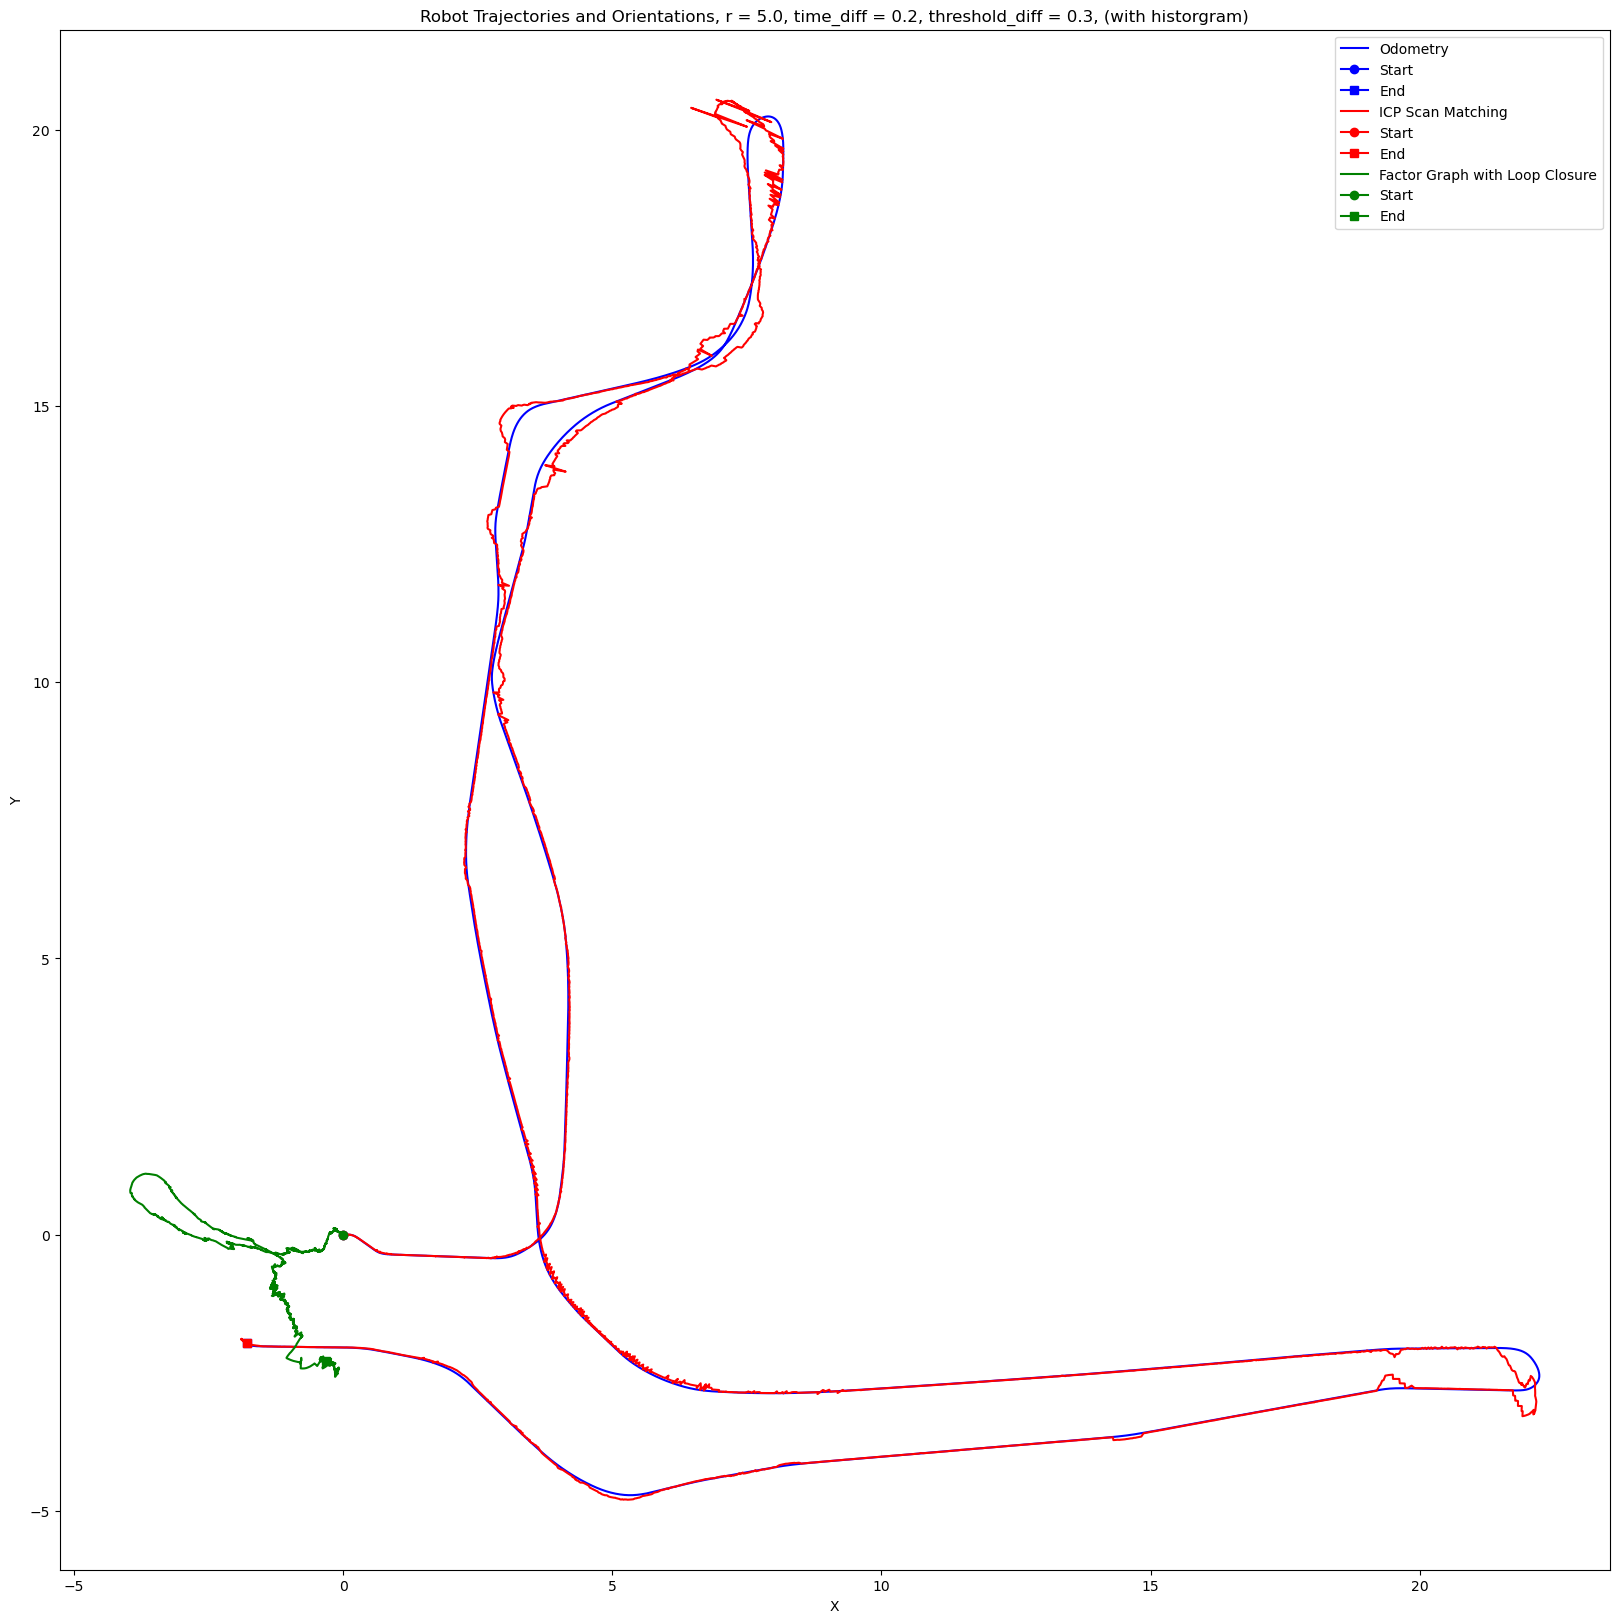

In [221]:
labels = [
    "Odometry",
    "ICP Scan Matching",
    "Factor Graph with Loop Closure"
]
title = "Robot Trajectories and Orientations, r = " + str(r) + ", time_diff = " + str(min_time_diff) + ", threshold_diff = " + str(threshold_diff) + ", (with historgram)"
plot_N_trajectories([poses_odom, poses_scan_matching, opt_poses], labels=labels, title=title, figsize=(20, 20))

In [83]:
#----------------------------------------------------------------------------
# Build occupancy grid map
# access map with ogm.grid_map, access log odd map with ogm.grid_map_log_odds
res = 0.05
ogm = OccupancyGridMap(res, 30., 30., -30., -30.)
ogm.build_map(opt_poses, z_ts_filtered)
#----------------------------------------------------------------------------

Building the map...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4956/4956 [06:18<00:00, 13.09it/s]


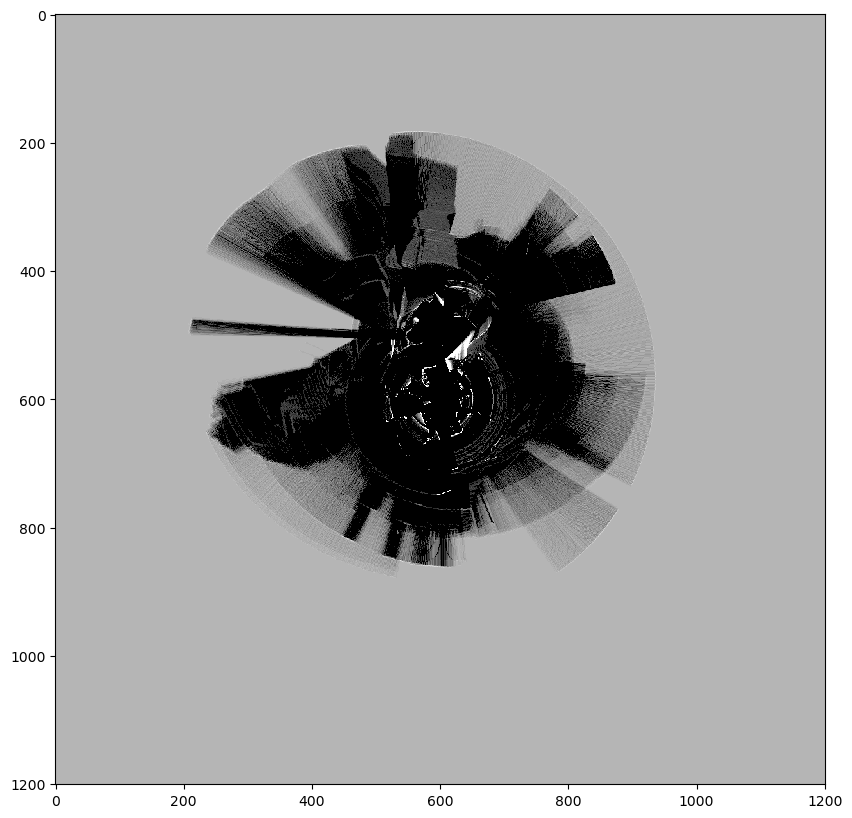

In [84]:
ogm.plot_log_odds_map()

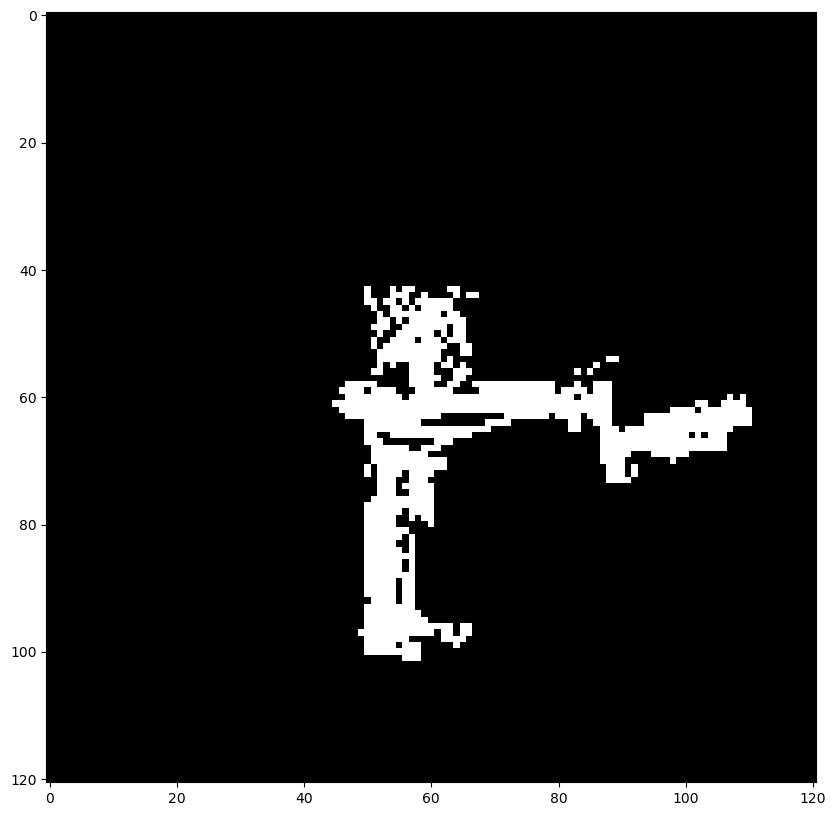

In [66]:
ogm.plot_map()

In [22]:
# Transformation from camera frame to robot's body frame (obtained from CAD)
p_rc = np.array([0.16766, 0., 0.38001])
R_rc = np.array([
    [ np.cos(rd(18.)), 0, np.sin(rd(18.))],
    [               0, 1,               0],
    [-np.sin(rd(18.)), 0, np.cos(rd(18.))]
])
T_rc = np.eye(4)
T_rc[:3, :3]  = R_rc
T_rc[:3,  3]  = p_rc

# Camera's intrinsic matrix
K = np.array([
    [585.05,      0, 242.94],
    [     0, 585.05, 315.84],
    [     0,      0,      1]
])

texture_map = generate_texture_map(
    dataset_num,
    opt_poses,
    kinect,
    encoder,
    ogm,
    T_rc,
    K,
    return_point_clouds=False
)

Generating texture map...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2289/2289 [05:32<00:00,  6.88it/s]


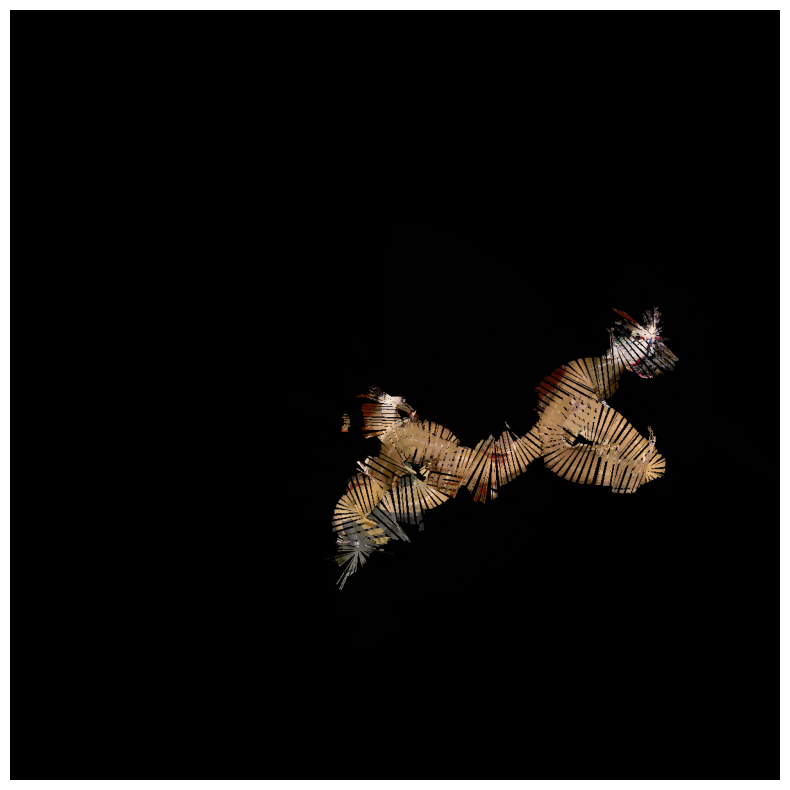

In [23]:
plot_texture_map(texture_map)